In [2]:
from datetime import datetime, date

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime 
import re
from matplotlib.font_manager import FontProperties      #自訂字型，顯示中文
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False  #解決座標軸負數的負號顯示問題
import matplotlib as mpl                            
mpl.rcParams['figure.figsize'] = (20,12)               #自訂圖片大小
mpl.rcParams.update({'font.size': 16})                 #自訂圖片文字大小
from IPython.display import display                    #在jupyter顯示每個欄位
pd.options.display.max_columns = None                 #显示默认值，解释器读取此值并显示此值作为显示上限的行
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')

# 忽略警告訊息
import warnings
warnings.filterwarnings('ignore')

In [3]:
al = pd.read_csv('./al.csv')

In [4]:
al = al[['orders_id','orders_dt','member_id','total_price','market_qty','sup_name']]

al=al.loc[al.sup_name!='團購']

al['orders_dt']=al['orders_dt'].astype('datetime64')
# al['member_id']=al['member_id'].astype('object')
# al['orders_id']=al['orders_id'].astype('object')

In [5]:
# 第1步： 為每一位消費者創建RFM變量
df_RFM = al.groupby('member_id').agg({'orders_dt': lambda y: (al['orders_dt'].max().date() - y.max().date()).days, 
                                      'orders_id'  : lambda y: len(y.unique()) , 
                                      'total_price': lambda y: round(y.sum(),2),
                                        'sup_name' : lambda y: len(y.unique()) ,                  
                                      'market_qty' : lambda y: round(y.sum(),2) }) 

df_RFM.columns = ['Recency','Frequency','Monetary','item','market_qty'] 

In [6]:
df_RFM = df_RFM.reset_index()

member_id_min = al.groupby('member_id').orders_dt.min()
orders_dt_max = al.orders_dt.max()

join_date = pd.DataFrame(orders_dt_max-member_id_min)
join_date = join_date.rename(columns = {'orders_dt':'joinperiod'})

df_RFM = pd.merge(df_RFM , join_date , on = 'member_id' , how = 'inner')

df_RFM['joinperiod'] = df_RFM['joinperiod']/np.timedelta64(1,'D')

df_RFM['member_id']=df_RFM['member_id'].astype('object')
df_RFM['joinperiod'] = df_RFM['joinperiod'].astype('int64')

print(df_RFM.dtypes)

df_RFM.head()

member_id     object
Recency        int64
Frequency      int64
Monetary       int64
item           int64
market_qty     int64
joinperiod     int64
dtype: object


,member_id,Recency,Frequency,Monetary,item,market_qty,joinperiod
0,5,855,1,949,1,1,855
1,7,78,2,1620,1,6,86
2,12,72,4,5244,2,16,820
3,35,893,1,762,1,1,893
4,46,508,1,529,1,1,508


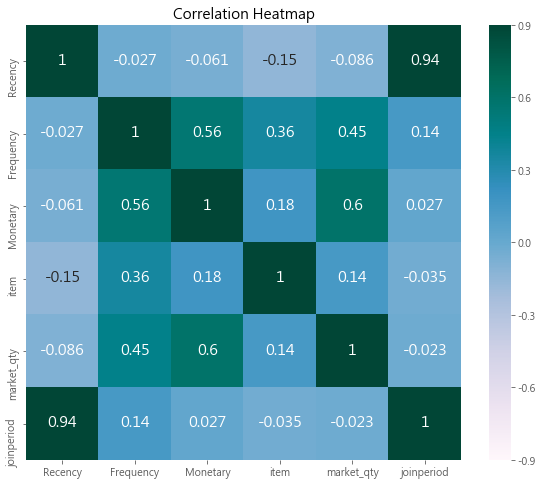

In [7]:
#相關係數
df_RFM1 = df_RFM[['Recency','Frequency','Monetary','item','market_qty','joinperiod']]

df_RFM_corr = df_RFM1.corr()

plt.figure(figsize = (10, 8))

# 繪製相關係數 (correlations) 的 Heatmap

# data:數據 square:是否是正方形 vmax:最大值 vmin:最小值 robust:排除極端值影響

sns.heatmap(df_RFM_corr, square=True, cmap = 'PuBuGn', annot = True , vmax=0.9
            , vmin= -0.9 ,robust=True , annot_kws={'size': 15})

plt.title('Correlation Heatmap');

### RFM 利用R M作2:8分

In [8]:
# 另一種分法 2 8 分 （dff_RFM）

dff_RFM = df_RFM[['member_id', 'Recency' ,'Frequency' ,'Monetary']]

Quantiles = dff_RFM.quantile(q=[0.8]) 
print(Quantiles) 

dff_RFM['R'] = np.where(df_RFM['Recency'] <= int(Quantiles.Recency.values), 2, 1) 
dff_RFM['F'] = np.where(df_RFM['Frequency'] >= int(Quantiles.Frequency.values), 2, 1) 
dff_RFM['M'] = np.where(df_RFM['Monetary'] >= int(Quantiles.Monetary.values), 2, 1) 

dff_RFM.head()


     Recency  Frequency  Monetary
0.8    758.0        1.0    2280.0


,member_id,Recency,Frequency,Monetary,R,F,M
0,5,855,1,949,1,2,1
1,7,78,2,1620,2,2,1
2,12,72,4,5244,2,2,2
3,35,893,1,762,1,2,1
4,46,508,1,529,2,2,1


           Recency  Frequency  Monetary
Recency       1.00      -0.03     -0.06
Frequency    -0.03       1.00      0.56
Monetary     -0.06       0.56      1.00


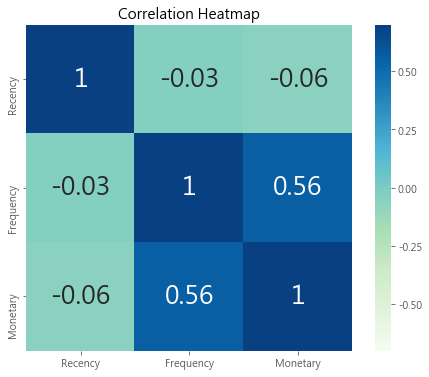

In [9]:
#相關係數
df_RFM2 = dff_RFM[['Recency' ,'Frequency' ,'Monetary']]
df_RFM3 = df_RFM2.corr()

df_RFM3 = round(df_RFM3,2)

print(df_RFM3)


plt.figure(figsize = (8, 6))
# 繪製相關係數 (correlations) 的 Heatmap
sns.heatmap(df_RFM3, cmap = 'GnBu', vmin = -0.7 , annot = True, vmax = 0.7 ,
            square = True , robust=True , annot_kws={'size': 25})
plt.title('Correlation Heatmap');

In [10]:
# To do the 2 x 2 matrix we will only use Recency & Monetary 
#計算 RMScore

dff_RFM['RMScore'] = dff_RFM.M.map(str) + dff_RFM.R.map(str) 
dff_RFM = dff_RFM.reset_index() 


df_RFM_SUM = dff_RFM.groupby('RMScore').agg({'member_id': lambda y: len(y.unique()), #人數
                                            'Frequency': lambda y: round(y.mean(),0), 
                                            'Recency': lambda y: round(y.mean(),0), 
                                            'R': lambda y: round(y.mean(),0), 
                                            'M': lambda y: round(y.mean(),0), 
                                            'Monetary': lambda y: round(y.mean(),0)}) 

df_RFM_SUM = df_RFM_SUM.sort_values('RMScore', ascending=False) 
df_RFM_SUM.reset_index()

,RMScore,member_id,Frequency,Recency,R,M,Monetary
0,22,9614,2,345,2,2,4628
1,21,2038,2,885,1,2,3992
2,12,37108,1,348,2,1,1001
3,11,9454,1,920,1,1,957


In [11]:
# 1) Average Monetary Matrix 

df_RFM_M = df_RFM_SUM.pivot(index='M', columns='R', values='Monetary') 
df_RFM_M = df_RFM_M.reset_index().sort_values(['M'], ascending = False).set_index(['M']) 

print(pd.DataFrame(df_RFM_M))

print('\n')
# 2) Number of Customer Matrix 

df_RFM_C = df_RFM_SUM.pivot(index='M', columns='R', values='member_id') 
df_RFM_C= df_RFM_C.reset_index().sort_values(['M'], ascending = False).set_index(['M']) 


print(pd.DataFrame(df_RFM_C))

# 3) Recency Matrix


R     1     2
M            
2  3992  4628
1   957  1001


R     1      2
M             
2  2038   9614
1  9454  37108



## 用R F M作五份 並與購買的商品作分群


In [12]:
#df_RFM 標準化

def normalize_value(x):
   
    x = ((x - min(x)) / ( max(x) - min(x) ) - 0.5) * 2
     
    return x

df_RFM0 = df_RFM.iloc[:,0:7]
df_RFM0['Recency'] = normalize_value(df_RFM['Recency'])
df_RFM0['Frequency'] = normalize_value(df_RFM['Frequency'])
df_RFM0['Monetary'] = normalize_value(df_RFM['Monetary'])
df_RFM0['item'] = normalize_value(df_RFM['item'])
df_RFM0['market_qty'] = normalize_value(df_RFM['market_qty'])
df_RFM0['joinperiod'] = normalize_value(df_RFM['joinperiod'])

df_RFM0 = round(df_RFM0,2)

In [23]:
quantiles

{'Recency': {0.25: -0.69, 0.5: -0.27, 0.75: 0.15},
 'Frequency': {0.25: -1.0, 0.5: -1.0, 0.75: -1.0},
 'Monetary': {0.25: -0.99, 0.5: -0.99, 0.75: -0.99}}

In [21]:
# rfmSegmentation 幫rfm 平均分成四等分

quantile_r = df_RFM0["Recency"].quantile(q=[0.25,0.5,0.75])
quantile_f = df_RFM0["Frequency"].quantile(q=[0.25,0.5,0.75])
quantile_m = df_RFM0["Monetary"].quantile(q=[0.25,0.5,0.75])

quantiles = {"Recency" : quantile_r.to_dict() , 
             "Frequency" : quantile_f.to_dict(),
             "Monetary" : quantile_m.to_dict()}

rfmSegmentation = df_RFM0

def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
 
def FClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

def MClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

rfmSegmentation['R_Quartile'] = rfmSegmentation['Recency'].apply(RClass, args=('Recency',quantiles))
rfmSegmentation['F_Quartile'] = rfmSegmentation['Frequency'].apply(FClass, args=('Frequency',quantiles))
rfmSegmentation['M_Quartile'] = rfmSegmentation['Monetary'].apply(MClass, args=('Monetary',quantiles))


rfmSegmentation = rfmSegmentation[['member_id','R_Quartile','F_Quartile','M_Quartile']]

In [22]:
rfmSegmentation.head()

,member_id,R_Quartile,F_Quartile,M_Quartile
0,5,1,1,1
1,7,4,4,1
2,12,4,4,4
3,35,1,1,1
4,46,2,1,1


In [18]:
#R M 2:8 分成四等分後 每群 購買的商品總數量

df_RFM4 = dff_RFM[['member_id','RMScore']]
scend = pd.merge(df_RFM4, first, on ='member_id' , how = 'inner')

scend.groupby('RMScore').sum()

,R_Quartile,F_Quartile,M_Quartile,3Q,偉星包子,南端果園,參騏鯖魚,吳媽媽包子,和定食,四喜,埔里游大哥,大樹楊水得,大樹老張水果,大樹金鑽,小杜包子,川琪進口水果,快車肉乾,恆田農場,慕鈺華蔥油餅,成功大閘蟹,拉拉山森境果園,拿破崙,月亮上的蛋,木瓜班長,村長芒果,欣奇農場,洪氏鮮蝦,洪瑞珍三明治,洽富,洽通,牛雜大王,皇宮月亮蝦餅,立家,美濃橙蜜香,老媽拌麵,老林記,良品開飯,花蓮縣餅,菇果,蓮霧大王,謝開飯,車臣紅龍果,逸湘齋滴雞精,金牌大師滴雞精,開飯逸湘齋,頂焰,香帥蛋糕,鮮果工坊,麟洛果菜市場,麻豆柚強牧場鮮乳文旦
RMScore,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11,9454,12298,10252,64.0,0.0,72.0,0.0,57.0,24.0,0.0,0.0,26.0,65.0,0.0,54.0,1703.0,720.0,53.0,1930.0,0.0,0.0,454.0,0.0,131.0,70.0,24.0,167.0,109.0,63.0,0.0,0.0,3962.0,0.0,742.0,17.0,89.0,2022.0,88.0,0.0,49.0,206.0,100.0,324.0,443.0,244.0,0.0,0.0,0.0,159.0,386.0
12,106307,44965,42694,202.0,125.0,5.0,95.0,226.0,24.0,39.0,13.0,1240.0,48.0,115.0,2.0,839.0,12928.0,5.0,3165.0,48.0,54.0,335.0,221.0,12.0,55.0,28.0,1311.0,4926.0,99.0,587.0,2036.0,11632.0,3302.0,2105.0,1.0,1113.0,8617.0,3424.0,16.0,3.0,1222.0,6.0,883.0,2184.0,10624.0,44.0,912.0,293.0,12.0,467.0
21,2038,3790,8152,7.0,0.0,24.0,0.0,3.0,0.0,0.0,0.0,1.0,5.0,0.0,1.0,159.0,181.0,8.0,88.0,0.0,0.0,37.0,0.0,16.0,3.0,11.0,13.0,66.0,19.0,0.0,0.0,2600.0,0.0,37.0,3.0,8.0,141.0,24.0,0.0,9.0,210.0,3.0,290.0,837.0,128.0,0.0,0.0,0.0,22.0,71.0
22,27777,21494,38456,16.0,2.0,1.0,7.0,4.0,6.0,7.0,8.0,231.0,20.0,53.0,0.0,176.0,6233.0,6.0,814.0,127.0,17.0,52.0,67.0,10.0,27.0,15.0,410.0,1618.0,96.0,220.0,407.0,10486.0,696.0,469.0,0.0,293.0,1469.0,384.0,7.0,10.0,805.0,1.0,1680.0,3579.0,3384.0,99.0,250.0,25.0,14.0,188.0


## k-means 分群

In [19]:
from sklearn.cluster import Birch
from sklearn.cluster import KMeans
from sklearn import cluster, datasets, metrics

# 迴圈  跑太久 想看k=？最好

# silhouette_avgs = []
# ks = range(2,10)
# for k in ks:
#     kmeans_fit = cluster.KMeans(n_clusters = k).fit(base)
#     cluster_labels = kmeans_fit.labels_
#     silhouette_avg = metrics.silhouette_score(base, cluster_labels)
#     silhouette_avgs.append(silhouette_avg)

# # 作圖並印出 k = 2 到 10 的績效
# plt.bar(ks, silhouette_avgs)
# plt.show()
# print(silhouette_avgs)

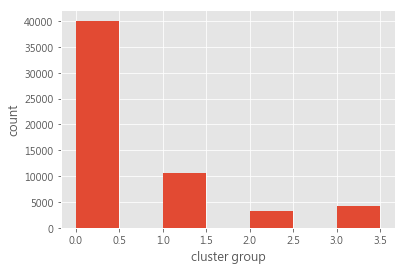

In [20]:
# 使用KMeans分類 ，K=4

cluster = KMeans(n_clusters = 4)
predictions = cluster.fit_predict(base)

# 繪製分類的直方圖
plt.xlabel('cluster group')
plt.ylabel('count')
bins = np.arange(0, 4 ,0.5) # fixed bin size
plt.hist(cluster.labels_, bins=bins)
plt.show()